In [35]:
from datetime import timedelta, datetime

from matplotlib import pyplot as plt

from src.stock_history.klines import KLinesStockHistory
from src.training.extractors.config import DataExtractionConfig
from src.training.extractors.klines_preparer import KLinesStockHistoryExtractor
from src.training.extractors.vision_binance_extractor import VisionBinanceExtractor
from src.training.position.short_position import ShortPositionFabric, ShortPositionParameters


def daterange(start_date, end_date):
    current = start_date
    while current < end_date:
        yield current
        current = current + timedelta(days=1)


### Download

In [3]:
csv_filenames = []

binance_downloader = VisionBinanceExtractor(
    currency=DataExtractionConfig.CURRENCY,
    timestamp=DataExtractionConfig.TIMESTAMP,
)

for curr_date in daterange(DataExtractionConfig.START_DATE, DataExtractionConfig.END_DATE):
    print(curr_date)
    binance_downloader.download_file(report_date=curr_date)
    csv_filenames.append(
        binance_downloader.unzip_file(report_date=curr_date),
    )


2025-07-01 00:00:00
2025-07-02 00:00:00
2025-07-03 00:00:00
2025-07-04 00:00:00
2025-07-05 00:00:00
2025-07-06 00:00:00
2025-07-07 00:00:00
2025-07-08 00:00:00
2025-07-09 00:00:00


In [4]:
csv_filenames

['data\\spot\\daily\\klines\\BTCUSDT\\1m\\BTCUSDT-1m-2025-07-01.csv',
 'data\\spot\\daily\\klines\\BTCUSDT\\1m\\BTCUSDT-1m-2025-07-02.csv',
 'data\\spot\\daily\\klines\\BTCUSDT\\1m\\BTCUSDT-1m-2025-07-03.csv',
 'data\\spot\\daily\\klines\\BTCUSDT\\1m\\BTCUSDT-1m-2025-07-04.csv',
 'data\\spot\\daily\\klines\\BTCUSDT\\1m\\BTCUSDT-1m-2025-07-05.csv',
 'data\\spot\\daily\\klines\\BTCUSDT\\1m\\BTCUSDT-1m-2025-07-06.csv',
 'data\\spot\\daily\\klines\\BTCUSDT\\1m\\BTCUSDT-1m-2025-07-07.csv',
 'data\\spot\\daily\\klines\\BTCUSDT\\1m\\BTCUSDT-1m-2025-07-08.csv',
 'data\\spot\\daily\\klines\\BTCUSDT\\1m\\BTCUSDT-1m-2025-07-09.csv']

### CreatePosition

#### Read data


In [2]:
history_extractor = KLinesStockHistoryExtractor(
    currency=DataExtractionConfig.CURRENCY,
    timestamp=DataExtractionConfig.TIMESTAMP,
)

klines_window = KLinesStockHistory()

for curr_date in daterange(DataExtractionConfig.START_DATE_READ, DataExtractionConfig.END_DATE_READ):
    print(curr_date)
    klines_window = klines_window.concat(
        stock_history=history_extractor.extract_history(curr_date),
    )


2025-07-02 00:00:00
2025-07-03 00:00:00
2025-07-04 00:00:00
2025-07-05 00:00:00
2025-07-06 00:00:00
2025-07-07 00:00:00
2025-07-08 00:00:00


#### Create Short Position

In [30]:
parameters = ShortPositionParameters(
    leverage = 10,
    quote_qty = 200,  # QUOTE CURRENCY (USDT)
    max_duration = timedelta(days=1, hours=0),
    stop_loss = 10,  # QUOTE CURRENCY (USDT)
    take_profit = 10,  # QUOTE CURRENCY (USDT)
)

short_position_fabric = ShortPositionFabric(
    short_position_parameters=parameters,
    klines_history=klines_window,
)

short_position = short_position_fabric.open(
    start_datetime=datetime(year=2025, month=7, day=3, hour=8, minute=0),
)

short_position.estimate()
print(short_position.get_result())


ShortPositionResult(pnl=np.float64(-10.95182710278683), duration=Timedelta('0 days 01:23:59.999999'))


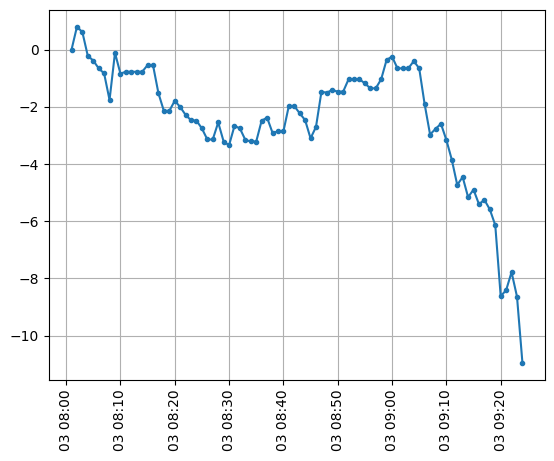

In [47]:
ax = plt.plot(
    short_position.get_close_datetime_logging(),
    short_position.get_pnl_logging(),
    marker='.',
)

plt.grid(True)
plt.tick_params(axis='x', rotation=90)

#### Generate samples